# CNN Improvement

### **Motivation**

* The performance of the CNN baseline can be improved by increasing the number of Conv layers and Max pool layers. This way we can capture more features and make the predictions better.
* The CNN baseline was also overfitting so we can add regularization using dropout technique. 

## Description

To address the problem, we use the LenNet5() architecture. This way we increase the number of Conv layers and linear layers,thus, increasing the total number of learnable parameters and capturing more features. We will also try the dropout technique to check if the model is overfitting or if it is the problem of lack of data.

## Architecture
![label_ss](./images/cnn_improvement.png)


## Implementation

In [1]:
import sys
sys.path.append("..")

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np
import torchvision
import torchvision.transforms as transforms
import tqdm
from torch.utils.data import Dataset
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import os
from src.dataset import *
from src.utils import *
import torch.optim as optim

import matplotlib
from torch.utils.data import DataLoader

### Model definition

In [3]:
class LeNet5_convnet(nn.Module):
    def __init__(self):

        super(LeNet5_convnet, self).__init__()

        # CL1: 3 x 144 x 256 --> 50 x 144 x 256
        self.conv1 = nn.Conv2d(3, 50, kernel_size=3, padding='same')

        # MP1: 50 x 144 x 256 --> 50 x 72 x 128 
        self.pool1 = nn.MaxPool2d(2, 2)

        # CL2: 50 x 72 x 128 --> 100 x 72 x 128
        self.conv2 = nn.Conv2d(50, 100, kernel_size=3, padding='same')

        # MP2: 100 x 72 x 128 --> 100 x 36 x 64
        self.pool2 = nn.MaxPool2d(2, 2)

        # LL1:   100 x 36 x 64 = 230400 -->  100
        self.linear1 = nn.Linear(230400, 100)
        
        # can be used in training
        self.dropout = nn.Dropout(0.2)

        # LL2:   100  -->  6
        self.linear2 = nn.Linear(100, 6)

    def forward(self, x, drop=False):

        # CL1: 3 x 144 x 256 --> 50 x 144 x 256
        x = self.conv1(x)
        x = F.relu(x)

        # MP1: 50 x 144 x 256 --> 50 x 72 x 128 
        x = self.pool1(x)

        # CL2: 50 x 72 x 128 --> 100 x 72 x 128
        x = self.conv2(x)
        x = F.relu(x)

        # MP2: 100 x 72 x 128 --> 100 x 36 x 64
        x = self.pool2(x)

        # LL1:   100 x 36 x 64 = 230400 -->  100
        x = x.view(-1, 230400)
        
        x = self.linear1(x)
        x = F.relu(x)
        if drop:
            x = self.dropout(x)
        
        # LL2:   100  -->  6
        x = self.linear2(x)

        return x

In [4]:
# training function
def train(model, dataloader, optimizer, criterion, train_data, device):
    print("Training")
    model.train()
    counter = 0
    train_running_loss = 0.0
    train_running_error = 0.0
    for i, data in tqdm(
        enumerate(dataloader), total=int(len(train_data) / dataloader.batch_size)
    ):
        
        counter += 1
        data, target = data["image"].to(device), data["label"].to(device)
        optimizer.zero_grad()
        outputs = model(data, drop=False)
        # apply sigmoid activation to get all the outputs between 0 and 1
        outputs = torch.sigmoid(outputs)
        loss = criterion(outputs, target)
        train_running_loss += loss.detach().item()
        error = get_error( outputs.detach() , target, batch_size)
        train_running_error += error
        
        # backpropagation
        loss.backward()
        # update optimizer parameters
        optimizer.step()

        
    train_loss = train_running_loss / counter
    total_error = train_running_error/counter
    return train_loss, total_error

In [5]:
def validate(model, dataloader, criterion, val_data, device):
    print("Validating")
    model.eval()
    counter = 0
    val_running_loss = 0.0
    val_running_error = 0.0
    with torch.no_grad():
        for i, data in tqdm(
            enumerate(dataloader), total=int(len(val_data) / dataloader.batch_size)
        ):
            counter += 1
            data, target = data["image"].to(device), data["label"].to(device)
            outputs = model(data)
            # apply sigmoid activation to get all the outputs between 0 and 1
            outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, target)
            val_running_loss += loss.item()
            error = get_error( outputs, target, batch_size)
            val_running_error += error
        val_loss = val_running_loss / counter
        val_error = val_running_error / counter
    return val_loss, val_error

### Model instantiation

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet5_convnet()
model = model.to(device)
display_num_param(model)
print(model)
lr = 0.0001
epochs = 10
batch_size = 32
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss()

There are 23087206 (23.09 million) parameters in this neural network
LeNet5_convnet(
  (conv1): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=230400, out_features=100, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear2): Linear(in_features=100, out_features=6, bias=True)
)


### Data Loading

In [7]:
# train dataset
train_data = ImageDataset(train=True)
# validation dataset
valid_data = ImageDataset(train=False)
# train data loader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# validation data loader
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)



Number of training images: 2065
Number of test images: 365


### Train

In [8]:
train_loss = []
valid_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, total_epoch_error = train(
        model, train_loader, optimizer, criterion, train_data, device
    )
    valid_epoch_loss, valid_epoch_error = validate(model, valid_loader, criterion, valid_data, device)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print("Train Error: ", total_epoch_error)
    print(f"Val Loss: {valid_epoch_loss:.4f}")
    print(f"Val Error: ", valid_epoch_error)
    

Epoch 1 of 10
Training


  0%|                                                                                           | 0/64 [00:00<?, ?it/s]C:\Users\Rishabh\anaconda3\envs\deeplearn_course\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
65it [00:08,  7.54it/s]                                                                                                


Validating


12it [00:01,  6.97it/s]                                                                                                


Train Loss: 0.4703
Train Error:  20.89743638267884
Val Loss: 0.6400
Val Error:  30.381945396463077
Epoch 2 of 10
Training


65it [00:23,  2.75it/s]                                                                                                


Validating


12it [00:02,  5.75it/s]                                                                                                


Train Loss: 0.3180
Train Error:  13.108974729592983
Val Loss: 0.6085
Val Error:  24.348959140479565
Epoch 3 of 10
Training


65it [00:23,  2.74it/s]                                                                                                


Validating


12it [00:02,  5.59it/s]                                                                                                


Train Loss: 0.2231
Train Error:  8.421474557656508
Val Loss: 0.7088
Val Error:  29.861111690600712
Epoch 4 of 10
Training


65it [00:23,  2.73it/s]                                                                                                


Validating


12it [00:02,  5.34it/s]                                                                                                


Train Loss: 0.1638
Train Error:  5.873397593028271
Val Loss: 0.7498
Val Error:  27.083333830038708
Epoch 5 of 10
Training


65it [00:23,  2.71it/s]                                                                                                


Validating


12it [00:02,  5.76it/s]                                                                                                


Train Loss: 0.1208
Train Error:  3.9743590999681215
Val Loss: 0.7948
Val Error:  25.91145895421505
Epoch 6 of 10
Training


65it [00:26,  2.45it/s]                                                                                                


Validating


12it [00:02,  5.15it/s]                                                                                                


Train Loss: 0.0927
Train Error:  2.7964744344353676
Val Loss: 0.9837
Val Error:  25.34722313284874
Epoch 7 of 10
Training


65it [00:29,  2.18it/s]                                                                                                


Validating


12it [00:02,  4.94it/s]                                                                                                


Train Loss: 0.0733
Train Error:  2.0592949252862196
Val Loss: 1.0257
Val Error:  27.256945023934048
Epoch 8 of 10
Training


65it [00:32,  2.02it/s]                                                                                                


Validating


12it [00:02,  4.29it/s]                                                                                                


Train Loss: 0.0652
Train Error:  1.9391026075642843
Val Loss: 1.0566
Val Error:  27.517361814777058
Epoch 9 of 10
Training


65it [00:33,  1.91it/s]                                                                                                


Validating


12it [00:02,  4.36it/s]                                                                                                


Train Loss: 0.0437
Train Error:  1.0817307914392307
Val Loss: 1.1574
Val Error:  25.694445396463077
Epoch 10 of 10
Training


65it [00:35,  1.81it/s]                                                                                                


Validating


12it [00:03,  3.81it/s]                                                                                                

Train Loss: 0.0352
Train Error:  0.9615384830305209
Val Loss: 1.1742
Val Error:  26.432292411724728


### Test

In [9]:
actors = np.array(CLASSES)
print('actors: ', actors)
# prepare the test dataset and dataloader
test_data = ImageDataset(train=False)
print(test_data[0]['image'].shape, test_data[0]['label'].shape)
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

actors:  ['chandler' 'joey' 'monica' 'phoebe' 'rachel' 'ross']
Number of test images: 365
torch.Size([3, 144, 256]) torch.Size([6])


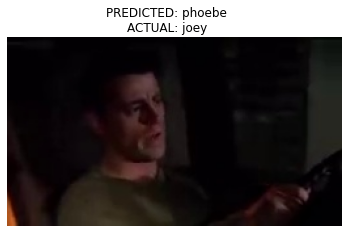

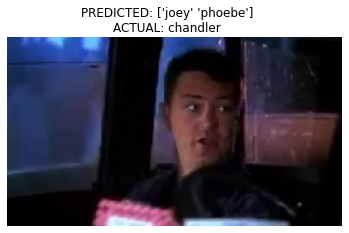

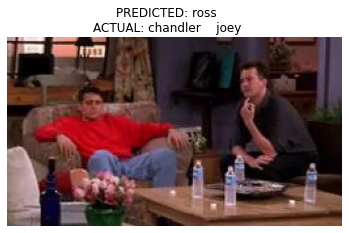

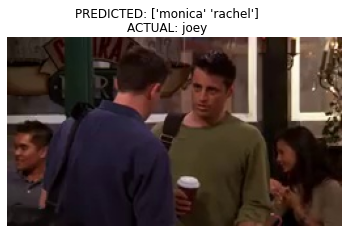

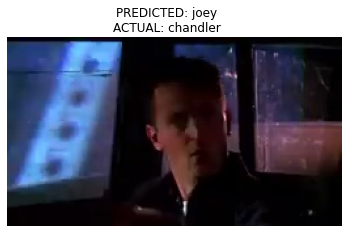

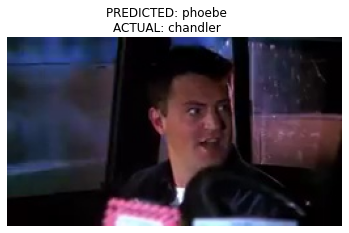

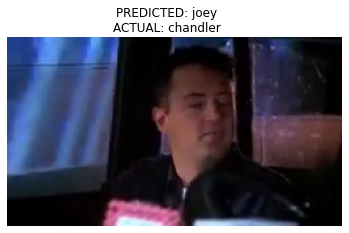

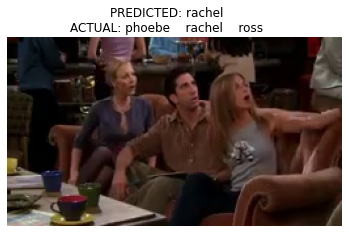

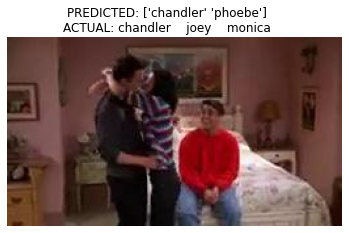

Test Error:  27.884615961830693


In [10]:
model.eval()
test_running_error = 0.0
output_list= []
target_list = []
for counter, data in enumerate(test_loader):
    
    image, target = data["image"].to(device), data["label"]
    # get all the index positions where value == 1
    target_indices = [i for i in range(len(target[0])) if target[0][i] == 1]

    # get the predictions by passing the image through the model
    outputs = model(image, False)
    outputs = torch.sigmoid(outputs)
    outputs = outputs.detach().cpu()
    lab = torch.where(outputs>=0.5,1,0)[0]
    pred = torch.where(lab==1)
    error = get_error( outputs, target, 1)
    
    output_list.append(outputs.numpy())
    target_list.append(target.numpy())
    
    test_running_error += error
    
    string_predicted = ""
    string_actual = ""
    for i in range(len(pred)):
        string_predicted += f"{actors[pred[i]]}    "
    for i in range(len(target_indices)):
        string_actual += f"{actors[target_indices[i]]}    "
        
    if 10< counter < 20:
        image = image.squeeze(0)
        image = image.detach().cpu().numpy()
        image = np.transpose(image, (1, 2, 0))
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"PREDICTED: {string_predicted}\nACTUAL: {string_actual}")
        plt.show()
    
test_error = test_running_error / counter
print(f"Test Error: ", test_error)

out = np.array(output_list).squeeze(axis=1)
tar = np.array(target_list).squeeze(axis=1)



In [11]:
f1 = get_f1_score(tar, out)
precision = get_precision_score(tar, out)
recall = get_recall_score(tar, out)
print("f1 score: ", f1)
print('Precision: ', precision)
print('Recall: ', recall)

f1 score:  0.3273776908023483
Precision:  0.3666666666666667
Recall:  0.3378538812785388


C:\Users\Rishabh\anaconda3\envs\deeplearn_course\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Results

For a CNN with Lenet5 architecture, the below are the results after training for 10 epocs:

### Without Dropout
* Train Loss: 0.0352
* Train Error:  0.9615384830305209
* Val Loss: 1.1742
* Val Error:  26.432292411724728
* We observe that the Train Loss and Train error decreases after each epoch. However, the Validation error may increase or decrease after each epoch (overfitting).
* Test Error:  27.884615961830693
* F1 score:  0.3273776908023483
* Precision:  0.3666666666666667
* Recall:  0.3378538812785388
* The Test error is 27.884% and we have a F1 score of 0.3273
* Learnable Parameters: 23.09 million

### With Dropout
* Train Loss: 0.0822
* Train Error:  2.868589833378792
* Val Loss: 0.9539
* Val Error:  27.34375111758709
* We observe that the Train Loss and Train error decreases after each epoch. However, the Validation error may increase or decrease after each epoch (overfitting).
* Test Error:  28.846154488868766
* F1 score:  0.19142857142857142
* Precision:  0.236986301369863
* Recall:  0.1745662100456621
* The Test error is 28.846% and we have a F1 score of 0.1914
* Learnable Parameters: 23.09 million

## Discussion

* The CNN improvement performs better than the CNN baseline as confirmed by the F1 score. F1 score for CNN baseline was 0.3005 and for CNN improvement model is 0.3273. This is because the Lenet5 architecture model captures more paramaters and features. This way it is able to do better predictions.
* We also observe that when we use dropout to reduce overfitting in the CNN, it increases the Train Loss but adversely affects the performance of our network. This actually shows that we need more data to make better predictions. The model would overfit for the current size of the dataset. We need a larger dataset to check if the model can learn better and maybe then we can think of reducing the overfitting.